In [1]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy import signal, special, sparse
import sympy

Import der Audiodatei als Array

In [2]:
y, sr = sf.read("Bach.wav")

Konstanten

In [3]:
#Dimension
n=1

#Anzahl der Channel der Sounddatei, erwartet wird 1 oder 2
channel=y.ndim

#Geschwindigkeiten alle in m/s
v=343  #Schalllgeschwindigkeit in Luft

#Abstand Quelle und Emfänger zu Beginn in m
r=10

Wandelt den dreidimensionalen Schalldruck in f(t) um

In [4]:
def entko(h):
    return h*4*np.pi*r

Wandelt wieder in den Druck in der entsprechenden Dimension zurück

In [5]:
def verko(h):
    if n == 1:
        return h*v/2
    if n % 2 == 0:
        return (h*(-1)**(n/2-1)*(n+1)*(np.pi)**((n-1)/2) / (
            4*(2*np.pi)**(n-1)*v**(n-2)*special.gamma((n+3)/2)))
    else:
        return (h*(-1)**((n-3)/2)*n*(np.pi)**((n-2)/2) / (
            8*(2*np.pi)**(n-2)*v**(n-3)*r*special.gamma((n+2)/2)))

Bestimmt die numerische Ableitung d-ter Ordnung

In [6]:
def abl(self, d):
    eit=self
    for i in range(0, d):
        eit=np.gradient(eit, 1/sr, edge_order=2)
    return eit

Faltungsfunktion

In [7]:
def falt(self, theta, d):
 
    if channel ==1:
        zw11=signal.convolve(abl(entko(self),d),theta) #Diskrete Faltung mit Ableitung
        zw21=zw11[:len(self)]/sr  #Die diskrete Faltung wird als Grenzfall der Faltung behandelt
        lsg=verko(zw21)
        
    else:  #Wie im Mono-Fall, nur wird die Faltung auf beide Kanäle angewandt
        zw11=signal.convolve(abl(entko(self[:,0]),d),theta)
        zw12=signal.convolve(abl(entko(self[:,1]),d),theta)
        zw21=zw11[:len(self)]/sr
        zw22=zw12[:len(self)]/sr
        lsg=np.empty([len(zw21),2])
        lsg[:,0]=verko(zw21)
        lsg[:,1]=verko(zw22)
        
    return lsg

Effektivwert

In [8]:
def effw(self):
    return np.sqrt(np.mean(np.square(self)))

### Dimensionenabhängige Fälle

In [30]:
if n==1:
    theta=np.ones(len(y)*2)  #Erstellt den zu f(t) zugehörigen Faltungskern für n=1
    
    lsg=falt(y, theta,0)
    
    #Mittelt die Werte des eindimensionalen Falls
    f=5000  #Länge der Intervalle in die die Datei aufgeteilt wird
    h=int(len(lsg)/f) #Anzahl an Intervallen in die die Datei aufgeteilt wird
    if len(lsg)%f!=0:h+=1
    if channel ==1:
        for i in range(0,h):
            lsg[i*f:(i+1)*f]=lsg[i*f:(i+1)*f]-np.mean(lsg[i*f:(i+1)*f])
    else:
        for i in range(0,h):
            lsg[i*f:(i+1)*f,0]=lsg[i*f:(i+1)*f,0]-np.mean(lsg[i*f:(i+1)*f,0])
            lsg[i*f:(i+1)*f,1]=lsg[i*f:(i+1)*f,1]-np.mean(lsg[i*f:(i+1)*f,1])

In [14]:
if n%2==0:
    theta=np.empty([len(y)])  #Erstellt den zu f(t) zugehörige Faltungskern für n%2=0
    for i in range(0, len(theta)):
        theta[i]=(i+1/2)/sr*((i+1/2)/sr+2*r/v)  
        #T wird um 1/2 Indizes verschoben um die Singularität bei 0 zu umgehen
    theta=1/np.sqrt(theta)
    lsg=falt(y,theta, n-2)

In [10]:
if n==3:
    lsg=y

In [54]:
if n%2!=0 and n>3:
    if channel ==1:
        lsg=verko(abl(entko(y),n-3))

    else: 
        if channel ==2:
            zw11=abl(entko(y[:,0]),n-3)
            zw12=abl(entko(y[:,1]),n-3) 
            lsg=np.empty([len(y),2])
            lsg[:,0]=verko(zw11)
            lsg[:,1]=verko(zw12)

Exportiert und normiert die resultierende Lösung

In [32]:
norm=lsg/np.absolute(lsg).max()*0.99  #normalisiert die Lösung
sf.write('1d.wav', norm, sr)  #erstellt eine neue Audiodatei im Ordner

Plot der Lösung

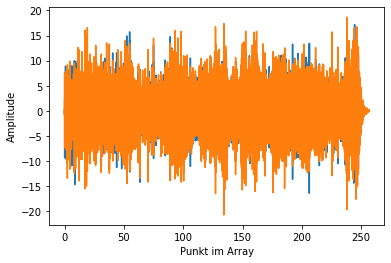

In [33]:
t = np.arange(0, len(lsg)/sr, 1/sr)
plt.plot(t, lsg)  #plot
plt.xlabel('Zeit in s')
plt.ylabel('Amplitude')
plt.show()  #show plot

Plot der ursprünglichen Datei

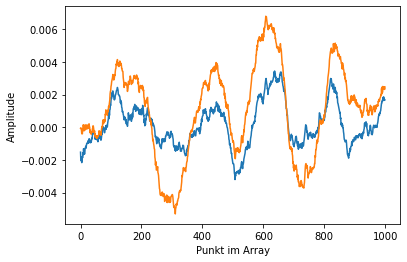

In [11]:
t = np.arange(0, len(y)/sr, 1/sr)
plt.plot(t,y)  #plot
plt.xlabel('Zeit in s')
plt.ylabel('Amplitude')
plt.show()  #show plot

Differenz der Schalldruckpegel in dB

In [34]:
print(20*np.log10(effw(lsg)/effw(y)))

25.950667793381108
